# Análise Exploratória - Mapeamento de Criminalidade no Ceará

Realizar uma análise exploratória de dados (EDA) de crimes por arma de fogo, roubos e homicídios

## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.GraficoHelper import GraficoHelper as grh

## Carregar o dataset de 2014 até hoje, exceto os 30 dias mais recentes

In [2]:
# Separar as colunas desejáveis do conjunto de dados
colunas = ['MUNICIPIO', 'NATUREZA DO FATO', 'ARMA UTILIZADA', 'DATA DA MORTE', 'SEXO', 'IDADE']

# Carregar dataset e determinar as variáveis categóricas
df_carga = pd.read_csv(r'../data/processed/sspds-ce/dataset_consolidado.csv', sep=";", usecols=colunas, 
    dtype={
        'MUNICIPIO':'category', 'NATUREZA DO FATO':'category', 'ARMA UTILIZADA':'category', 
        'SEXO':'category', 'IDADE':'category' })

## Formatar e converter colunas

### Normalizar a coluna de Data do Óbito

In [3]:
# Dividir o dataset entre os formatos de data #1 e #2
df_data1 = pd.DataFrame(df_carga[df_carga['DATA DA MORTE'].str.contains("-")])
df_data2 = pd.DataFrame(df_carga[df_carga['DATA DA MORTE'].str.contains("/")])

# Quebrar em colunas para ajustar a formatação #1
df_data1[['D', 'M', 'Y']] = df_data1['DATA DA MORTE'].str.split('-', 2, expand=True)
df_data1['D'] = df_data1['D'].str.zfill(2)
df_data1['M'] = df_data1['M'].str.capitalize()
df_data1['M'] = df_data1['M'].replace('Fev', 'Feb').replace('Mai', 'May').replace('Out', 'Oct').replace('Dez', 'Dec')
df_data1['Y'] = df_data1['Y'].replace('15', '2015')
# Concatenar o formato #1
df_data1['DATA DA MORTE'] = df_data1['D']+"-"+df_data1['M']+"-"+df_data1['Y']

# Coverter dataset formato #1
df_data1['DATA'] = pd.to_datetime(df_data1['DATA DA MORTE'], format="%d-%b-%Y")
# Coverter dataset formato #2
df_data2['DATA'] = pd.to_datetime(df_data2['DATA DA MORTE'], format="%d/%m/%Y")

# Eliminar colunas sem uso
df_data1 = df_data1.drop(columns=['D','M','Y','DATA DA MORTE'])
df_data2 = df_data2.drop(columns=['DATA DA MORTE'])

# Juntar dataframes em um novo consolidado
df_consolidado = pd.concat([df_data1, df_data2])

### Normalizar coluna IDADE

In [4]:
# Substituir valores vazios de IDADE, por NaN para o tipo categórico
df_consolidado['IDADE'] = df_consolidado['IDADE'].replace('-', np.nan)
df_consolidado['IDADE'] = df_consolidado['IDADE'].astype('category')
df_consolidado['IDADE'].unique() # Identificar

['28', '67', '21', '16', '22', ..., '2', '87', '90', '94', '86']
Length: 97
Categories (96, object): ['0', '1', '10', '11', ..., '91', '92', '93', '94']

### Normalizar coluna NATUREZA DO FATO

In [5]:
# Verificar campos únicos de NATUREZA DO FATO, para formata-los
df_consolidado['NATUREZA DO FATO'] = df_consolidado['NATUREZA DO FATO'].replace('FEMINICÍDIO','FEMINICIDIO')
df_consolidado['NATUREZA DO FATO'] = df_consolidado['NATUREZA DO FATO'].replace('LESÃO CORPORAL SEGUIDA DE MORTE', 'LESAO CORPORAL SEGUIDA DE MORTE').replace('LESÃO CORPORAL SEGUIDO DE MORTE', 'LESAO CORPORAL SEGUIDA DE MORTE')
df_consolidado['NATUREZA DO FATO'] = df_consolidado['NATUREZA DO FATO'].astype('category')
df_consolidado['NATUREZA DO FATO'].unique() # Identificar

['LESAO CORPORAL SEGUIDA DE MORTE', 'ROUBO SEGUIDO DE MORTE (LATROCINIO)', 'HOMICIDIO DOLOSO', 'ROUBO SEGUIDO DE MORTE (LATROCÍNIO)', NaN, 'FEMINICIDIO', 'MORTE SUSPEITA']
Categories (6, object): ['FEMINICIDIO', 'HOMICIDIO DOLOSO', 'LESAO CORPORAL SEGUIDA DE MORTE', 'MORTE SUSPEITA', 'ROUBO SEGUIDO DE MORTE (LATROCINIO)', 'ROUBO SEGUIDO DE MORTE (LATROCÍNIO)']

### Normalizar coluna SEXO

In [6]:
# Verificar campos únicos de SEXO, para formata-los
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('-', np.nan)
df_consolidado['SEXO'] = df_consolidado['SEXO'].str.upper()
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('FEMININO','F').replace('FEMININO ','F').replace('F ','F')
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('MASCULINO','M').replace('MASCULINO ','M').replace('M ','M')
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('NÃO IDENTIFICADO', 'NAO IDENTIFICADO')
df_consolidado['SEXO'] = df_consolidado['SEXO'].replace('NÃO INFORMADO','NAO INFORMADO')
df_consolidado['SEXO'] = df_consolidado['SEXO'].astype('category')
df_consolidado['SEXO'].unique() # Identificar

['M', 'F', 'I', NaN, 'NAO IDENTIFICADO', 'NI', 'NAO INFORMADO']
Categories (6, object): ['F', 'I', 'M', 'NAO IDENTIFICADO', 'NAO INFORMADO', 'NI']

### Normalizar coluna ARMA UTILIZADA

In [7]:
# Verificar o campo ARMA UTILIZADA por valores únicos
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].str.upper()
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('OUTROS MEIOS', 'OUTROS').replace('ARMA OUTROS', 'OUTROS').replace('AMA OUTROS', 'OUTROS').replace('OUTRO', 'OUTROS')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('NÃO INFORMAD', 'NI').replace('MEIO NÃO INFORMADO', 'NI').replace('NÃO INFORMADO', 'NI')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('ARAMA BRANCA', 'ARMA BRANCA').replace('ARAMA DE BRANCA', 'ARMA BRANCA').replace('ARMA DE BRANCA', 'ARMA BRANCA')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].replace('ARMADE FOGO', 'ARMA DE FOGO').replace('ARAMA DE FOGO', 'ARMA DE FOGO').replace('ARMA ADE FOGO', 'ARMA DE FOGO').replace('ARMA D FOGO', 'ARMA DE FOGO').replace('ARMA FOGO', 'ARMA DE FOGO')
df_consolidado['ARMA UTILIZADA'] = df_consolidado['ARMA UTILIZADA'].astype('category')
df_consolidado['ARMA UTILIZADA'].unique() # Identificar

['ARMA BRANCA', 'ARMA DE FOGO', 'OUTROS', NaN, 'ARMA DE FOGO E ARMA', 'NI', 'ARMA DE FACA']
Categories (6, object): ['ARMA BRANCA', 'ARMA DE FACA', 'ARMA DE FOGO', 'ARMA DE FOGO E ARMA', 'NI', 'OUTROS']

### Normalizar coluna MUNICIPIO

In [8]:
# Normalizar os nomes dos municípios
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].astype('str').str.upper()
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].apply( lambda a: a.replace('Ç','C').replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U').replace('Ã','A').replace('Õ','O').strip() )
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].replace('-', np.nan)
df_consolidado['MUNICIPIO'] = df_consolidado['MUNICIPIO'].astype('category') # converter em categórica
df_consolidado['MUNICIPIO'].unique() # Identificar

['FORTALEZA', 'EUSEBIO', 'PACAJUS', 'JUAZEIRO DO NORTE', 'RUSSAS', ..., 'GRANJEIRO', 'POTIRETAMA', 'BAIXIO', 'JATI', 'JAGUARIBARA']
Length: 188
Categories (187, object): ['ABAIARA', 'ACARAPE', 'ACARAU', 'ACOPIARA', ..., 'URUOCA', 'VARJOTA', 'VARZEA ALEGRE', 'VICOSA DO CEARA']

## Prévia e informações preliminares sobre o Dataset

In [9]:
# Prévia dos dados
df_consolidado.head(5)

,MUNICIPIO,NATUREZA DO FATO,ARMA UTILIZADA,SEXO,IDADE,DATA
0,FORTALEZA,LESAO CORPORAL SEGUIDA DE MORTE,ARMA BRANCA,M,28,2014-07-01
1,EUSEBIO,ROUBO SEGUIDO DE MORTE (LATROCINIO),ARMA DE FOGO,M,67,2014-07-01
2,FORTALEZA,HOMICIDIO DOLOSO,ARMA DE FOGO,F,21,2014-07-01
3,FORTALEZA,HOMICIDIO DOLOSO,ARMA DE FOGO,M,16,2014-07-01
4,EUSEBIO,HOMICIDIO DOLOSO,ARMA DE FOGO,M,22,2014-07-01


In [10]:
# Informações preliminares sobre o dataset
print('Quantidade de linhas e colunas:', df_consolidado.shape)
print('Quantidade total de dados nulos:', df_consolidado.isna().sum().sum())

Quantidade de linhas e colunas: (29114, 6)
Quantidade total de dados nulos: 1635


In [11]:
# Tipo de dados
df_consolidado.dtypes

MUNICIPIO                 category
NATUREZA DO FATO          category
ARMA UTILIZADA            category
SEXO                      category
IDADE                     category
DATA                datetime64[ns]
dtype: object

### Onde estão os dados nulos?

In [12]:
df_consolidado.isna().sum()

MUNICIPIO              1
NATUREZA DO FATO      10
ARMA UTILIZADA        66
SEXO                   6
IDADE               1552
DATA                   0
dtype: int64

## Série temporal de crimes relatados

#### Cada registro representa um crime relatado

## Visão diária dos crimes

In [13]:
df_periodo_ocorrencias = df_consolidado[['DATA', 'IDADE']]
df_serie_temp = df_periodo_ocorrencias.groupby('DATA').size().to_frame('QDE').reset_index()
df_serie_temp.head(5)

,DATA,QDE
0,2014-05-01,5
1,2014-05-02,8
2,2014-05-03,10
3,2014-05-04,15
4,2014-05-05,10


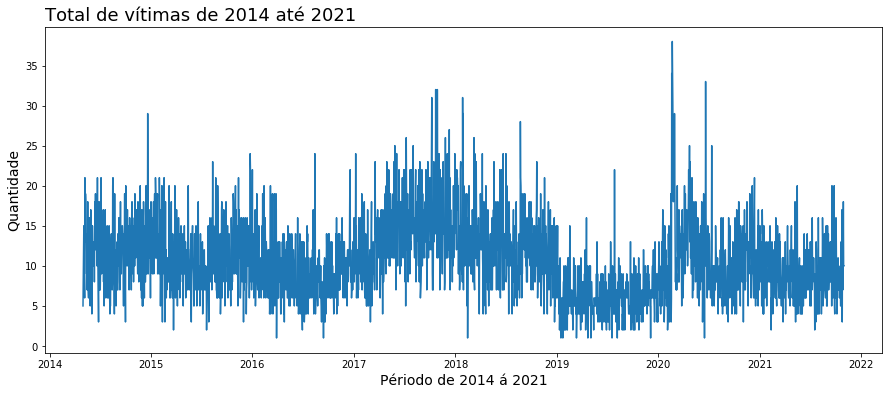

In [14]:
plt.figure(figsize=(15,6))
g = sns.lineplot(data=df_serie_temp,
            x = 'DATA',
            y = 'QDE'
            )
g.set_title('Total de vítimas de 2014 até 2021', loc='left', size=18)
g.set_xlabel('Périodo de 2014 á 2021', fontsize=14)
g.set_ylabel('Quantidade', fontsize=14)
plt.show()

## Visão mensal dos crimes

In [15]:
# Agrupar por mês em novo Dataframe
agrupamento_periodo_ocorrencias_mes = df_serie_temp.resample('M', on='DATA')
df_periodo_ocorrencias_mes = pd.DataFrame()
df_periodo_ocorrencias_mes['QDE'] = agrupamento_periodo_ocorrencias_mes['QDE'].sum()
df_periodo_ocorrencias_mes = df_periodo_ocorrencias_mes.reset_index()
df_periodo_ocorrencias_mes.head(5)

,DATA,QDE
0,2014-05-31,359
1,2014-06-30,373
2,2014-07-31,331
3,2014-08-31,307
4,2014-09-30,341


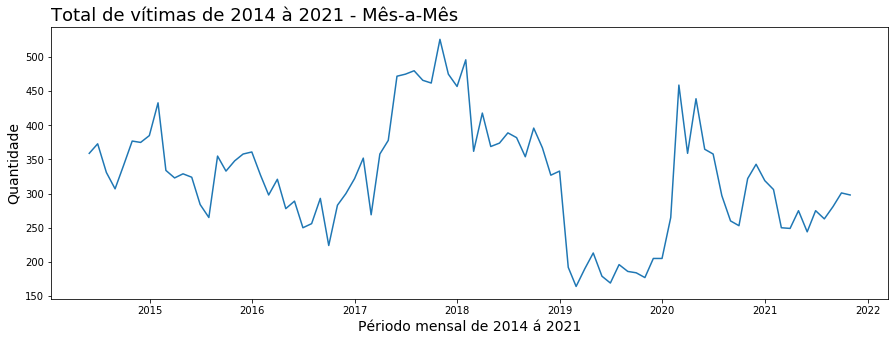

In [16]:
plt.figure(figsize=(15,5))
g = sns.lineplot(data=df_periodo_ocorrencias_mes,
            x = 'DATA',
            y = 'QDE'
            )
g.set_title('Total de vítimas de 2014 à 2021 - Mês-a-Mês', loc='left', size=18)
g.set_xlabel('Périodo mensal de 2014 á 2021', fontsize=14)
g.set_ylabel('Quantidade', fontsize=14)
plt.show()

In [17]:
# Detalhar as estatísticas de total de crimes baseada na quantidade de relatos
df_periodo_ocorrencias_mes.describe()

,QDE
count,90.000000
mean,323.488889
std,83.554093
min,164.000000
25%,266.000000
50%,325.500000
75%,368.500000
max,526.000000


## Agrupar ocorrências por sexo das vítimas

In [18]:
df_grupo_sexo = df_consolidado.groupby('SEXO').size().to_frame('TOTAL').reset_index()
df_grupo_sexo = df_grupo_sexo.sort_values(by=['TOTAL'], ascending=False)
df_grupo_sexo

,SEXO,TOTAL
2,M,26795
0,F,2295
1,I,11
3,NAO IDENTIFICADO,5
4,NAO INFORMADO,1
5,NI,1


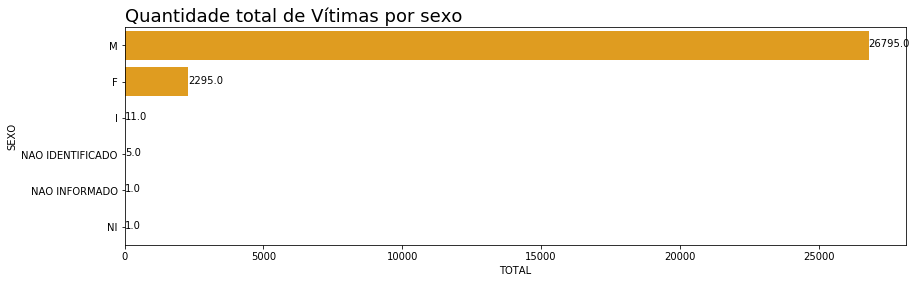

In [19]:
plt.figure(figsize=(14,4))
g = sns.barplot(data=df_grupo_sexo,
            x = 'TOTAL',
            y = 'SEXO',
            color='orange',
            order=df_grupo_sexo['SEXO']
            )
g.set_title('Quantidade total de Vítimas por sexo', loc='left', size=18)
grh.exibirValores(g, 'h')
plt.show()

## Agrupar por Município

### Visão geral

In [20]:
df_vitimas_por_municipio = df_consolidado.groupby('MUNICIPIO').size().to_frame('TOTAL').reset_index()
df_vitimas_por_municipio = df_vitimas_por_municipio.sort_values(by=['TOTAL'], ascending=False).head(15)
df_vitimas_por_municipio.head(5)

,MUNICIPIO,TOTAL
58,FORTALEZA,10048
43,CAUCAIA,2064
104,MARACANAU,1354
98,JUAZEIRO DO NORTE,831
169,SOBRAL,739


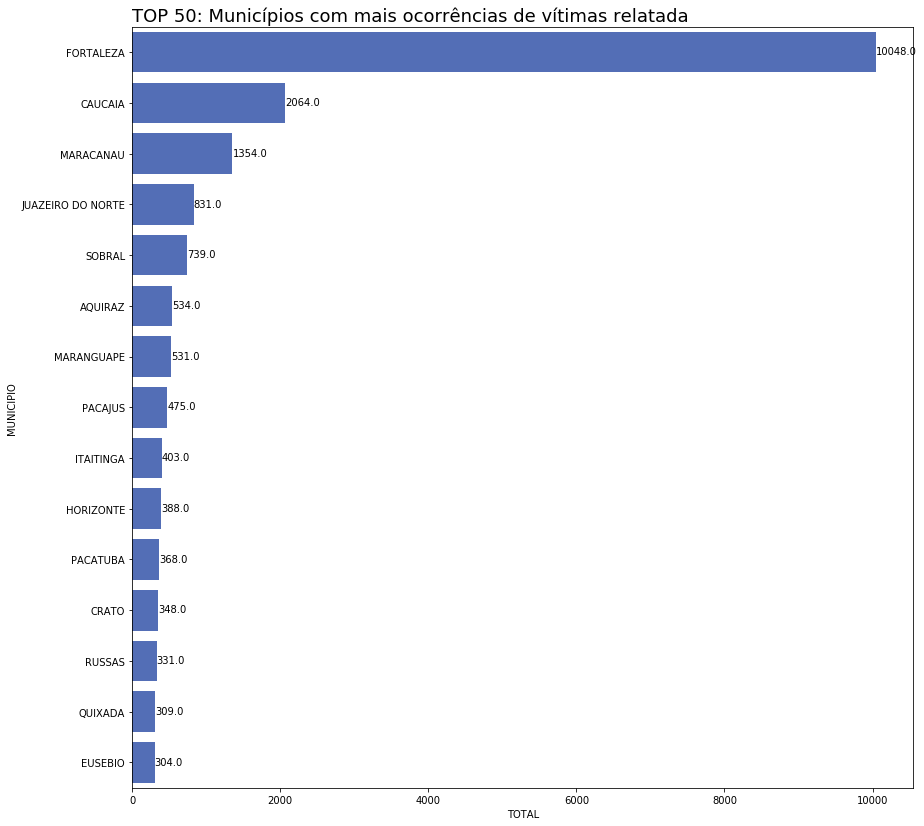

In [21]:
plt.figure(figsize=(14,14))
g = sns.barplot(data=df_vitimas_por_municipio,
            x = 'TOTAL',
            y = 'MUNICIPIO',
            color='#4267c7',
            order=df_vitimas_por_municipio['MUNICIPIO']
            )
g.set_title('TOP 50: Municípios com mais ocorrências de vítimas relatada', loc='left', size=18)
grh.exibirValores(g, 'h')
plt.show()

### Por vítimas homem

In [22]:
df_vitimas_sexo_x_municipio = df_consolidado[ df_consolidado['SEXO']=='M' ].groupby(['MUNICIPIO','SEXO']).size().to_frame('TOTAL').reset_index()
df_vitimas_sexo_x_municipio = df_vitimas_sexo_x_municipio.sort_values(by=['TOTAL'], ascending=False).head(15)
df_vitimas_sexo_x_municipio.head(5)

,MUNICIPIO,SEXO,TOTAL
350,FORTALEZA,M,9282
260,CAUCAIA,M,1848
626,MARACANAU,M,1264
590,JUAZEIRO DO NORTE,M,774
1016,SOBRAL,M,680


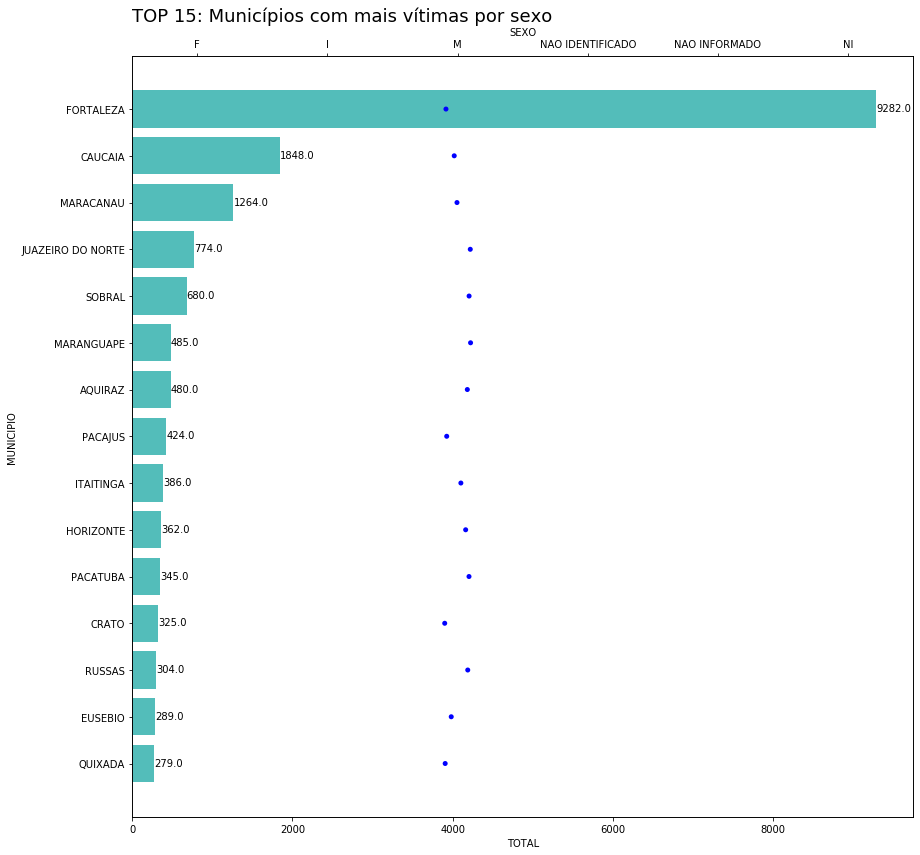

In [23]:
# exibir gráfico
plt.figure(figsize=(14,14))
g = sns.barplot(data=df_vitimas_sexo_x_municipio,
            x = 'TOTAL',
            y = 'MUNICIPIO',
            color='#42cecb',
            order=df_vitimas_sexo_x_municipio['MUNICIPIO']
            )
g.set_title('TOP 15: Municípios com mais vítimas por sexo', loc='left', size=18)
grh.exibirValores(g, 'h')

# exibir a outra coluna
ax2 = g.twiny()
sns.stripplot(x='SEXO', y='MUNICIPIO', data=df_vitimas_sexo_x_municipio, marker='o', color='blue', lw=5, ax=ax2)

plt.show()

### Por vítimas mulher

In [24]:
df_vitimas_sexo_f_municipio = df_consolidado[ df_consolidado['SEXO']=='F' ].groupby(['MUNICIPIO','SEXO']).size().to_frame('TOTAL').reset_index()
df_vitimas_sexo_f_municipio = df_vitimas_sexo_f_municipio.sort_values(by=['TOTAL'], ascending=False).head(15)
df_vitimas_sexo_f_municipio.head(5)

,MUNICIPIO,SEXO,TOTAL
348,FORTALEZA,F,761
258,CAUCAIA,F,214
624,MARACANAU,F,90
1014,SOBRAL,F,58
588,JUAZEIRO DO NORTE,F,56


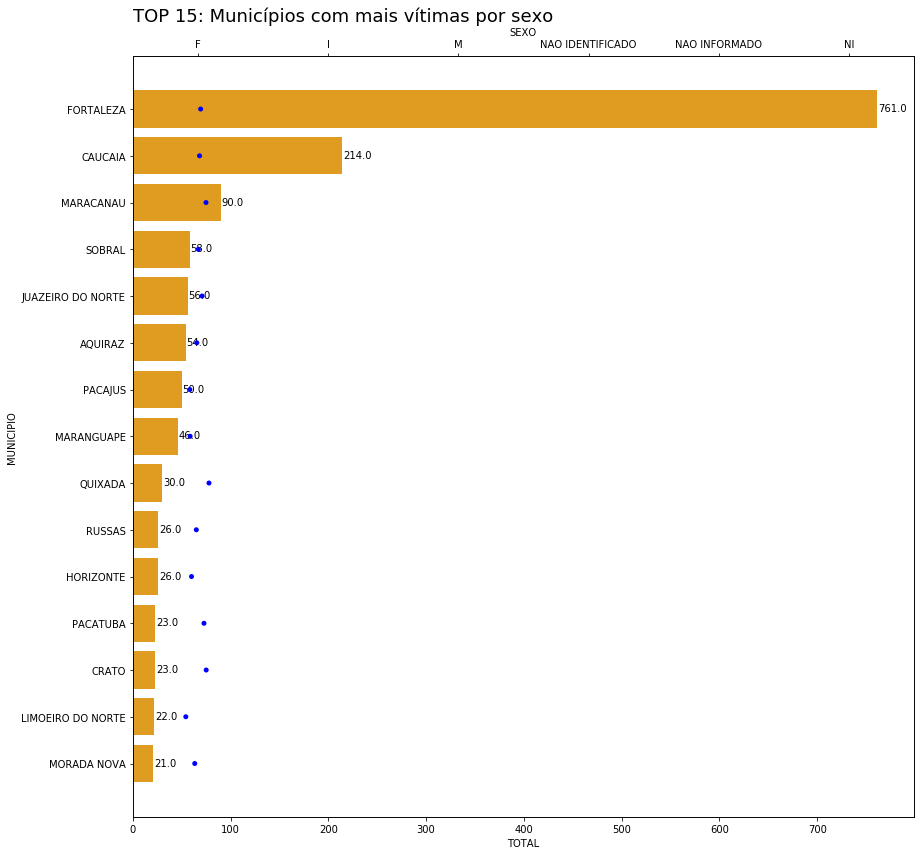

In [25]:
plt.figure(figsize=(14,14))
g = sns.barplot(data=df_vitimas_sexo_f_municipio,
            x = 'TOTAL',
            y = 'MUNICIPIO',
            color='orange',
            order=df_vitimas_sexo_f_municipio['MUNICIPIO']
            )
g.set_title('TOP 15: Municípios com mais vítimas por sexo', loc='left', size=18)
grh.exibirValores(g, 'h')

# exibir a outra coluna
ax2 = g.twiny()
sns.stripplot(x='SEXO', y='MUNICIPIO', data=df_vitimas_sexo_f_municipio, marker='o', color='blue', lw=5, ax=ax2)

plt.show()

### Série temporal de ocorrências nos 15 maiores município

In [26]:
# Agrupar por período e município em novo Dataframe
df_serie_temp_municipio = df_consolidado.groupby(['DATA','MUNICIPIO']).size().to_frame('QDE').reset_index()
df_serie_temp_municipio.head(5)

# periodicidade mensal
agrup_mes_municipio = df_serie_temp_municipio.resample('M', on='DATA')

# Define os 15 municipios com mais ocorrências
municips = ['FORTALEZA','CAUCAIA','MARACANAU','SOBRAU', 'JUAZEIRO DO NORTE', 
    'AQUIRAZ', 'PACAJUS', 'MARANGUAPE', 'QUIXADA', 'RUSSAS',
    'HORIZONTE', 'PACATUBA', 'CRATO', 'LIMOEIRO DO NORTE', 'MORADA NOVA']

df_serie_temp_municipio_plot = df_serie_temp_municipio[df_serie_temp_municipio['MUNICIPIO'].isin(municips)]

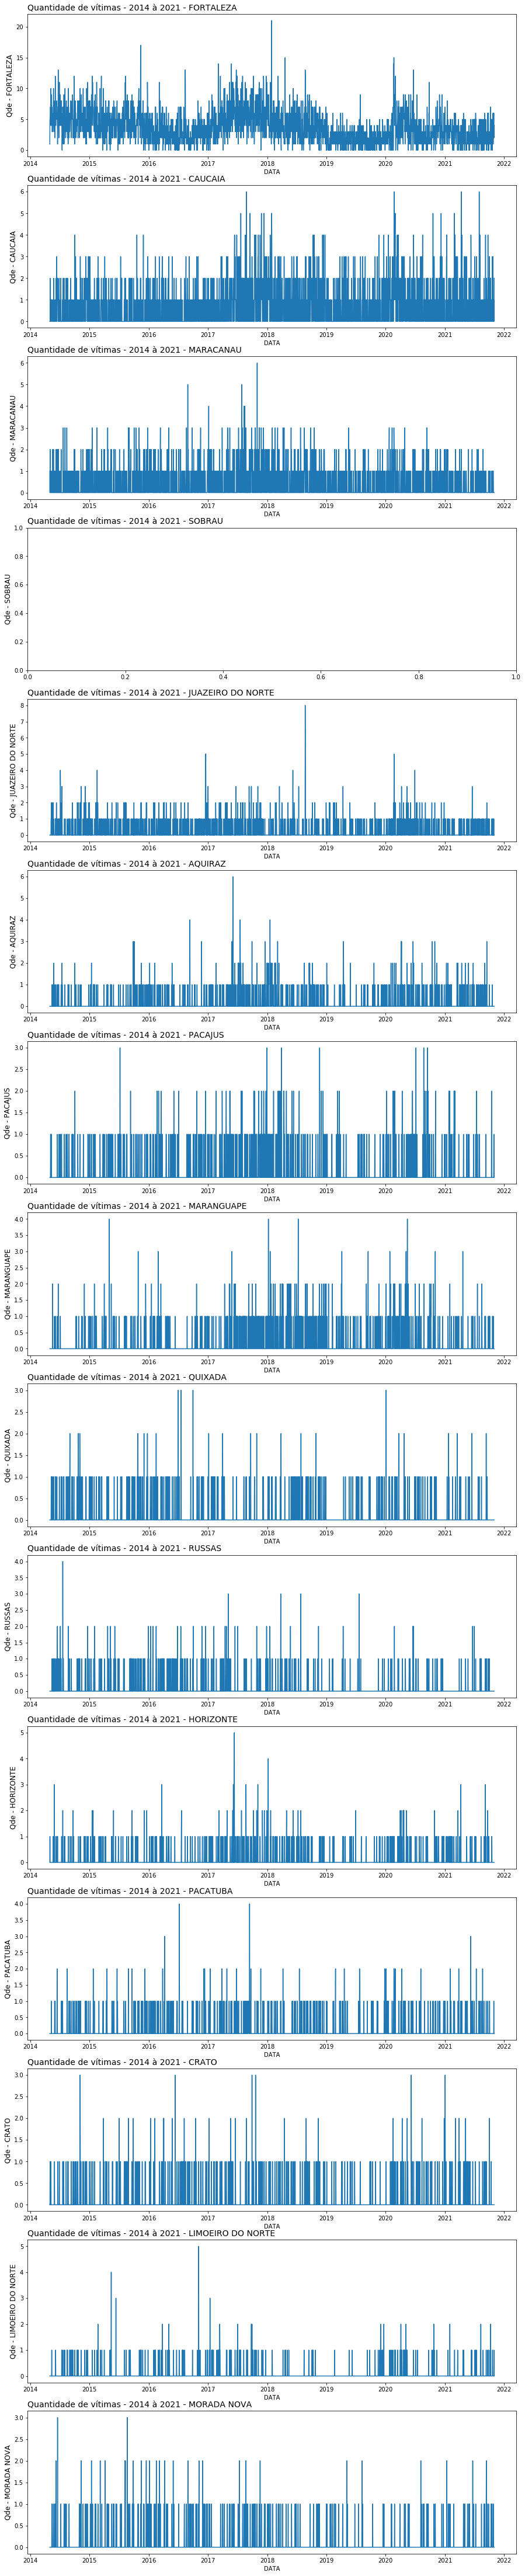

In [27]:
# plt.figure(figsize=(15,5))
fig, axes = plt.subplots(len(municips), figsize=(15, 80))

for curr_ax, curr_col in zip(axes.flat, municips):
    g = sns.lineplot(data=df_serie_temp_municipio_plot[df_serie_temp_municipio_plot['MUNICIPIO']==curr_col], 
        x='DATA', y='QDE',  ax=curr_ax)
    g.set_title(f'Quantidade de vítimas - 2014 à 2021 - {curr_col}', loc='left', size=14)
    g.set_ylabel(f'Qde - {curr_col}', fontsize=12)

plt.show()

#### Gerar arquivo formatado para o estudo

In [28]:
### Armazenar o dataframe com as transformações, em uma nova versão para processamento de dados
df_consolidado.to_csv('../data/processed/sspds-ce/dataset_consolidado_estudo.csv', sep=';', index=False)